# LeR: Lensed Gravitational Wave Rate Calculation - Complete Example

LeR is a comprehensive framework for simulating gravitational wave (GW) events and calculating their detection rates, including the effects of gravitational lensing. This notebook provides a complete example of simulating both lensed and unlensed CBC events and comparing their detection rates.

## Table of Contents

1. [Part 1: Basic GW Event Simulation and Rate Calculation](#part-1-basic-gw-event-simulation-and-rate-calculation)
   - [1.1 Initialize LeR](#11-initialize-ler)
   - [1.2 Simulate Unlensed GW Population](#12-simulate-unlensed-gw-population)
   - [1.3 Calculate Unlensed Detection Rates](#13-calculate-unlensed-detection-rates)
   - [1.4 Simulate Lensed GW Population](#14-simulate-lensed-gw-population)
   - [1.5 Calculate Lensed Detection Rates](#15-calculate-lensed-detection-rates)
   - [1.6 Compare Lensed and Unlensed Rates](#16-compare-lensed-and-unlensed-rates)
   - [1.7 Inspect Generated Parameters](#17-inspect-generated-parameters)
   - [1.8 Access Saved Data Files](#18-access-saved-data-files)
   - [1.9 Visualize Parameter Distributions](#19-visualize-parameter-distributions)

## Part 1: Basic GW Event Simulation and Rate Calculation

This section demonstrates how to simulate lensed and unlensed binary black hole mergers and calculate their detection rates.

### 1.1 Initialize LeR

The `LeR` class is the main interface for simulating gravitational lensing effects on GW events and calculating lensed rates. By default, it uses:
- **Event type:** BBH (Binary Black Hole)
- **Detectors:** H1, L1, V1 (LIGO Hanford, LIGO Livingston, Virgo)
- **Detector sensitivity:** `bilby` default O4 design sensitivity
- **Lens galaxy model:** Built-in population models

All outputs will be saved in the `./ler_data` directory by default.

In [1]:
# Import LeR class
from ler import LeR

# Initialize LeR with default settings
ler = LeR(verbose=True)

print("LeR initialized successfully!")
print(f"Output directory: {ler.ler_directory}")


Initializing LeR class...


Initializing LensGalaxyParameterDistribution class...


Initializing OpticalDepth class

comoving_distance interpolator will be loaded from ./interpolator_json/comoving_distance/comoving_distance_0.json
angular_diameter_distance interpolator will be loaded from ./interpolator_json/angular_diameter_distance/angular_diameter_distance_0.json
angular_diameter_distance interpolator will be loaded from ./interpolator_json/angular_diameter_distance/angular_diameter_distance_0.json
differential_comoving_volume interpolator will be loaded from ./interpolator_json/differential_comoving_volume/differential_comoving_volume_0.json
using ler available velocity dispersion function : velocity_dispersion_ewoud
velocity_dispersion_ewoud interpolator will be loaded from ./interpolator_json/velocity_dispersion/velocity_dispersion_ewoud_0.json
using ler available axis_ratio function : axis_ratio_rayleigh
axis_ratio_rayleigh interpolator will be loaded from ./interpolator_json/a

### 1.2 Simulate Unlensed GW Population

Generate a population of unlensed CBC (Compact Binary Coalescence) events. This step:
- Samples redshifts, masses, spins, and other GW parameters from source priors
- Calculates probability of detection (Pdet) for each event based on detector network sensitivity
- Stores output in `./ler_data/unlensed_param.json`

**Parameters:**
- `size`: Total number of events to sample
- `batch_size`: Events per batch (useful for resuming interrupted simulations)
- `resume`: If `False`, start fresh; if `True` (default), resume from the last saved batch
- `save_batch`: If `False` (default), save only at the end (faster); if `True`, save each batch

**Note:** For more realistic results, use `size >= 1,000,000` with `batch_size = 50,000`

In [28]:
# Simulate unlensed GW population
unlensed_param = ler.unlensed_cbc_statistics(size=100000, resume=True)

print(f"\nTotal unlensed events simulated: {len(unlensed_param['zs'])}")
print(f"Redshift range: {unlensed_param['zs'].min():.4f} to {unlensed_param['zs'].max():.4f}")
print(f"Sample redshift values: {unlensed_param['zs'][:5]}")

unlensed params will be stored in ./ler_data/unlensed_param.json
resuming from ./ler_data/unlensed_param.json
unlensed parameters already sampled.

Total unlensed events simulated: 100000
Redshift range: 0.0519 to 9.9972
Sample redshift values: [1.94427653 2.85335419 1.08817035 1.83683077 4.32494391]


### 1.3 Calculate Unlensed Detection Rates

Select only detectable events and calculate the detection rate. This function:
- Filters events based on probability of detection (Pdet) threshold
- Returns the rate in units of detectable events per year
- Stores detectable events in `./ler_data/unlensed_param_detectable.json`

In [9]:
# Calculate unlensed detection rate
rate_unlensed, unlensed_param_detectable = ler.unlensed_rate()

print(f"\n=== Unlensed Detection Rate ===")
print(f"Detectable unlensed rate: {rate_unlensed:.4e} events per year")
print(f"Total event rate: {ler.normalization_pdf_z:.4e} events per year")
print(f"Percentage of detectable events: {rate_unlensed/ler.normalization_pdf_z*100:.2e}%")

Getting unlensed_param from json file ./ler_data/unlensed_param.json...
total unlensed rate (yr^-1): 275.4598542515732
number of simulated unlensed detectable events: 335
number of simulated all unlensed events: 100000
storing detectable params in ./ler_data/unlensed_param_detectable.json

=== Unlensed Detection Rate ===
Detectable unlensed rate: 2.7546e+02 events per year
Total event rate: 8.2227e+04 events per year
Percentage of detectable events: 3.35e-01%


In [12]:
# View parameters of detectable unlensed events
print("Detectable unlensed event parameters:")
print(list(unlensed_param_detectable.keys()))

print("\nExample primary masses (source frame, first 5 events):")
print(unlensed_param_detectable['mass_1_source'][:5])

Detectable unlensed event parameters:
['zs', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'a_1', 'a_2', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'pdet_L1', 'pdet_H1', 'pdet_V1', 'pdet_net']

Example primary masses (source frame, first 5 events):
[31.56451176 34.35373467 59.63890081 40.944049   31.21108929]


### 1.4 Simulate Lensed GW Population

Generate a population of lensed CBC events. This step:
- Generates unlensed source parameters (redshifts, masses, spins)
- Samples lens galaxy parameters (mass, position, ellipticity, etc.)
- Calculates lensed image parameters (magnification, arrival times, positions)
- Computes detectability for each image
- Stores output in `./ler_data/lensed_param.json`

**Parameters:**
- `size`: Total number of events to sample
- `resume`: If `False`, start fresh; if `True` (default), resume from the last saved batch
- `save_batch`: If `False` (default), save only at the end (faster); if `True`, save each batch

**Note:** Lensed event simulation can be computationally intensive. For large samples, consider:
- Reducing `batch_size` if experiencing memory issues
- Setting `save_batch=True` to save intermediate results

In [14]:
# Simulate lensed GW population
lensed_param = ler.lensed_cbc_statistics(size=100000, resume=True, save_batch=False)

print(f"\nTotal lensed events simulated: {len(lensed_param['zs'])}")
print(f"Redshift range: {lensed_param['zs'].min():.4f} to {lensed_param['zs'].max():.4f}")
print(f"Sample magnification values: {lensed_param['magnifications'][:5]}")

lensed params will be stored in ./ler_data/lensed_param.json
resuming from ./ler_data/lensed_param.json
lensed parameters already sampled.

Total lensed events simulated: 100000
Redshift range: 0.3525 to 9.9949
Sample magnification values: [[ 1.41990052 -0.07454954         nan         nan]
 [ 2.10362298 -0.1226839          nan         nan]
 [ 1.29232935 -0.11791078         nan         nan]
 [ 2.4060774  -0.32007167         nan         nan]
 [ 3.63604466 -1.20038151         nan         nan]]


### 1.5 Calculate Lensed Detection Rates

Select detectable lensed events and calculate the lensed detection rate. This function:
- Filters events based on Pdet threshold
- Returns the rate in units of detectable lensed events per year
- Stores detectable events in `./ler_data/lensed_param_detectable.json`

In [15]:
# Calculate lensed detection rate
rate_lensed, lensed_param_detectable = ler.lensed_rate()

print(f"\n=== Lensed Detection Rate ===")
print(f"Detectable lensed rate: {rate_lensed:.4e} events per year")
print(f"Total event rate: {ler.normalization_pdf_z:.4e} events per year")
print(f"Percentage of detectable events: {rate_lensed/ler.normalization_pdf_z*100:.2e}%")

Getting lensed_param from json file ./ler_data/lensed_param.json...
total lensed rate (yr^-1): 0.09305319315895054
number of simulated lensed detectable events: 91
number of simulated all lensed events: 100000
storing detectable params in ./ler_data/lensed_param_detectable.json

=== Lensed Detection Rate ===
Detectable lensed rate: 9.3053e-02 events per year
Total event rate: 8.2227e+04 events per year
Percentage of detectable events: 1.13e-04%


In [16]:
# View parameters of detectable lensed events
print("Detectable lensed event parameters:")
print(list(lensed_param_detectable.keys()))

print("\nExample lens parameters (first 5 events):")
print(f"Source redshifts (zs): {lensed_param_detectable['zs'][:5]}")
print(f"Lens redshifts (zl): {lensed_param_detectable['zl'][:5]}")
print(f"Einstein radii (theta_E): {lensed_param_detectable['theta_E'][:5]}")

Detectable lensed event parameters:
['zl', 'zs', 'sigma', 'theta_E', 'q', 'phi', 'gamma', 'gamma1', 'gamma2', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'a_1', 'a_2', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'x0_image_positions', 'x1_image_positions', 'magnifications', 'time_delays', 'image_type', 'n_images', 'x_source', 'y_source', 'effective_luminosity_distance', 'effective_geocent_time', 'effective_phase', 'pdet_net', 'L1', 'H1', 'V1']

Example lens parameters (first 5 events):
Source redshifts (zs): [0.89107377 2.19732945 1.92310568 2.85314615 1.26038803]
Lens redshifts (zl): [0.19175799 1.40685937 0.91021838 1.08410295 0.38846527]
Einstein radii (theta_E): [2.20029809e-06 8.82808854e-07 2.58691976e-06 1.20186436e-06
 1.52999595e-06]


### 1.6 Compare Lensed and Unlensed Rates

Compare the detection rates and analyze the rate enhancement due to gravitational lensing.

In [18]:
# Calculate and compare rates
rate_ratio = ler.rate_ratio()

print(f"\n=== Rate Comparison Summary ===")
print(f"Unlensed detectable rate: {rate_unlensed:.4e} events/year")
print(f"Lensed detectable rate: {rate_lensed:.4e} events/year")
print(f"Rate ratio (lensed/unlensed): {rate_ratio:.4f}")
print(f"Rate enhancement factor: {rate_ratio:.2f}x")
print(f"\nLensing magnifies the detection rate by a factor of {rate_ratio:.2f}")

unlensed_rate: 275.4598542515732
lensed_rate: 0.09305319315895054
ratio: 2960.2407494070762

=== Rate Comparison Summary ===
Unlensed detectable rate: 2.7546e+02 events/year
Lensed detectable rate: 9.3053e-02 events/year
Rate ratio (lensed/unlensed): 2960.2407
Rate enhancement factor: 2960.24x

Lensing magnifies the detection rate by a factor of 2960.24


You can also calculate rates and compare them simultaneously using:
```python
rate_ratio, unlensed_param_detectable, lensed_param_detectable = ler.rate_comparison_with_rate_calculation()
```

### 1.7 Inspect Generated Parameters

View the available parameters in the generated event population.

In [19]:
# View output directory and saved files
print(f"Output directory: {ler.ler_directory}")
print(f"\nSaved JSON files:")
for key, filename in ler.json_file_names.items():
    print(f"  {key}: {filename}")

Output directory: ./ler_data

Saved JSON files:
  ler_params: ler_params.json
  unlensed_param: unlensed_param.json
  unlensed_param_detectable: unlensed_param_detectable.json
  lensed_param: lensed_param.json
  lensed_param_detectable: lensed_param_detectable.json


### 1.8 Access Saved Data Files

Reload parameters from JSON files for further analysis.

In [21]:
from ler.utils import get_param_from_json, load_json

# Load detectable parameters from files
unlensed_param_detectable_loaded = get_param_from_json(
    ler.ler_directory + '/' + ler.json_file_names['unlensed_param_detectable']
)
lensed_param_detectable_loaded = get_param_from_json(
    ler.ler_directory + '/' + ler.json_file_names['lensed_param_detectable']
)

print(f"Unlensed parameters loaded: {list(unlensed_param_detectable_loaded.keys())}")
print(f"Lensed parameters loaded: {list(lensed_param_detectable_loaded.keys())}")

# Load the initialization parameters and rates
ler_params = load_json(ler.ler_directory + '/ler_params.json')
print(f"\n=== Saved Results ===")
print(f"Detectable unlensed rate: {ler_params['detectable_unlensed_rate_per_year']:.4e} per year")
print(f"Detectable lensed rate: {ler_params['detectable_lensed_rate_per_year']:.4e} per year")
print(f"Rate ratio: {ler_params['rate_ratio']:.4f}")

Unlensed parameters loaded: ['zs', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'a_1', 'a_2', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'pdet_L1', 'pdet_H1', 'pdet_V1', 'pdet_net']
Lensed parameters loaded: ['zl', 'zs', 'sigma', 'theta_E', 'q', 'phi', 'gamma', 'gamma1', 'gamma2', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'a_1', 'a_2', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'x0_image_positions', 'x1_image_positions', 'magnifications', 'time_delays', 'image_type', 'n_images', 'x_source', 'y_source', 'effective_luminosity_distance', 'effective_geocent_time', 'effective_phase', 'pdet_net', 'L1', 'H1', 'V1']

=== Saved Results ===
Detectable unlensed rate: 2.7546e+02 per year
Detectable lensed rate: 9.3053e-02 per year
Rate ratio: 2960.2407


### 1.9 Visualize Parameter Distributions

Create KDE (Kernel Density Estimation) plots to compare parameter distributions between unlensed and lensed populations.

getting gw_params from json file ler_data/unlensed_param_detectable.json...
getting gw_params from json file ler_data/lensed_param_detectable.json...


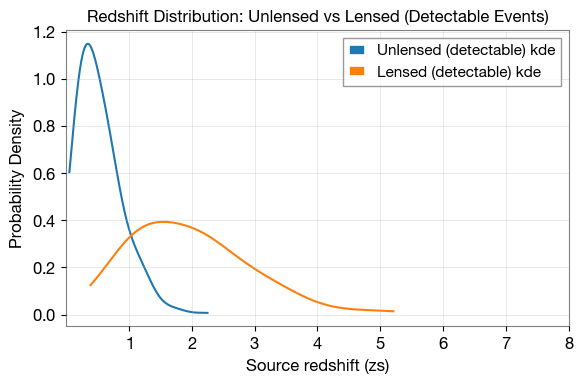

In [23]:
import matplotlib.pyplot as plt
from ler.utils import plots as lerplt

# Compare redshift distributions for unlensed and lensed detectable events
plt.figure(figsize=(6, 4))

# Unlensed distribution
lerplt.param_plot(
    param_name='zs',
    param_dict='ler_data/unlensed_param_detectable.json',
    plot_label='Unlensed (detectable)',
    histogram=False,
    kde=True,
    kde_bandwidth=0.5,
)

# Lensed distribution
lerplt.param_plot(
    param_name='zs',
    param_dict='ler_data/lensed_param_detectable.json',
    plot_label='Lensed (detectable)',
    histogram=False,
    kde=True,
    kde_bandwidth=0.5,
)

plt.xlim(0.001, 8)
plt.xlabel('Source redshift (zs)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.title('Redshift Distribution: Unlensed vs Lensed (Detectable Events)', fontsize=12, fontweight='bold')
plt.grid(alpha=0.4)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

---

## Summary

This notebook demonstrated the key features of the `LeR` class for modeling gravitational lensing effects on GW detection:

1. **Unlensed Simulation:** Simulating GW populations without lensing effects
2. **Lensed Simulation:** Simulating GW populations with gravitational lensing
3. **Rate Calculation:** Computing detection rates for both scenarios
4. **Rate Comparison:** Quantifying the enhancement of detection rates due to lensing
5. **Visualization:** Comparing parameter distributions between lensed and unlensed populations

**Key Takeaways:**
- Gravitational lensing can significantly enhance GW detection rates
- LeR automatically handles lens galaxy sampling and image parameter calculations
- Results are automatically saved for reproducibility and further analysis
- The framework supports batch processing for memory-efficient simulations

For more examples and detailed documentation, visit the [LeR documentation](https://ler.hemantaph.com).